# Image Classification of ATLAS Calorimeter Topo-Clusters (Quantized)

Here we will train quantized versions of some of our classifiers. We will be using `AutoQKeras`, and we will not quantize *all* of our classifiers but only the high-performing ones.

In [1]:
source = 'pion'
subdir = 'qpion3' # name for subdir holding models/plots
h5_name_suffix = 'tdata' # used for HDF5 files containing selected events, indices

# If true, force re-training even if a model already exists. Existing model will be lost!
overwriteModel = False

# If true, continue training and try to train to the last specified epoch.
# If EarlyStopping was used, this may result in trying to further train a "finished" network.
finishTraining = False

drawPlots = True

# If no file extension, uses native TensorFlow format (.tf).
# If 'h5', uses HDF5. HDF5 does not work for custom layers/classes! (unless you design them a certain way)
file_extension = '.h5'
if(file_extension != '' and '.' not in file_extension):
    file_extension = '.' + file_extension

## Quick Navigation:
TODO.

In [2]:
#import libraries and some constants
import os, sys, pathlib
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
#import ROOT as rt # I will use this for some plotting
#import uproot as ur

path_prefix = os.getcwd() + '/../'
plotpath = os.getcwd() +'/Plots/{}/'.format(subdir)
modelpath = os.getcwd() +'/Models/{}/'.format(subdir)

for dir in [plotpath,modelpath]:
    try:os.makedirs(dir)
    except: pass

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

# Custom tensorflow.keras callbacks
from util.keras.callbacks import GetCallbacks

# Classification-specific utils
from util.classification import training_util as ctu
from util.classification import plot_util as cpu
from util.classification import data_util as cdu

# Some qkeras stuff
from util.qkeras.energy import GetEnergy, GetCostReduction
from util.qkeras.aqk import AutoQuantization
from util.qkeras.io import GetCompiledModel
from util.qkeras.pruning import GetPrunedModel

from qkeras.utils import _add_supported_quantized_objects as add_qkeras_layers

# TensorFlow/Keras pruning stuff
import tensorflow_model_optimization as tfmot

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/02


In [3]:
# fancy display names for each pion type
pi_latex = {
    'p0': '\(\pi^{0}\)',
    'pp': '\(\pi^{\pm}\)',
}
pi_text = {
    'p0': 'pi0',
    'pp': 'pi+/-'
}

# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

Now, we will import our data from the `ROOT` files.

In [4]:
if(source == 'pion'):
    inputpath=path_prefix+'data/pion/'
    rootfiles = {        
        'p0':inputpath + 'user.mswiatlo.900246.PG_singlepi0_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root',
        'pp':inputpath + 'user.mswiatlo.900247.PG_singlepion_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root'
    }
    branches = [
                'clusterE', 'clusterECalib', 
                'clusterPt', 'clusterEta', 'clusterPhi', 
                'cluster_nCells', 'cluster_sumCellE', 
                'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY'
    ]        
else: assert(False)

In [5]:
# Prepare data
h5_name = inputpath + h5_name_suffix

pdata,pcells = mu.setupPionData(
    rootfiles, 
    branches=branches, 
    layers=layers, 
    balance_data=True, 
    n_max = 300000,
    verbose=True,
    load=True,
    save=True,
    filename=h5_name,
    match_distribution='cluster_ENG_CALIB_TOT',
    match_binning = (20000,0.,2000.),
    cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
    cut_values = [.2, (-0.7,0.7)],
    cut_types=['lower','window']
)

total = np.sum([len(x) for x in pdata.values()],dtype=int)
for key,frame in pdata.items():
    n = len(frame)
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=pi_text[key], b = n, c = 100. * n / total))
print("Total: {}".format(total))

pdata_merged, pcells_merged, plabels = cdu.DataPrep(pdata, 
                                                    pcells, 
                                                    layers, 
                                                    trainfrac=0.7,
                                                    filename=h5_name
                                                   )

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion/tdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/classifier/../data/pion/tdata_images.h5.
Number of pi0     events:     300000	(50.0%)
Number of pi+/-   events:     300000	(50.0%)
Total: 600000
Loading indices for key p0 from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion/tdata_indices.h5.
Loading indices for key pp from /local/home/jano/ml4pions/LCStudies/classifier/../data/pion/tdata_indices.h5.


We'll train the network on $\pi^+$ and $\pi^0$ events.

## TensorFlow/Keras prep

**Note:** Starting in May 2021, I've run into some issues with `tensorflow`/`tensorflow-gpu` not detecting/using GPU's. This issue is documented in a number of places, including [here](https://github.com/ContinuumIO/anaconda-issues/issues/12194). The current fix is to use an older version of `tensorflow` (and downgrading things is seldom a satisfying solution).

You can check GPU usage using `nvidia-smi`. Note that it appears to immediately show a python process using memory after running the setup cell below. Once training begins, you can check that this is actually being used by monitoring power consumption and volatile GPU memory usage (which should increase noticeably once you start actual training). TensorFlow may still print out info about broadcasting things to CPU, which by itself isn't an issue or sign that the GPU is not being used.

In [6]:
ngpu = 1
from util.classification.models import baseline_nn_model#, baseline_cnn_model, all_cnn_model, resnet
#from util.classification.models_exp import exp_merged_model

Let's prepare some callbacks (originally from our regression notebook).

In [7]:
models = {} # regular models
qmodels = {} # quantized models
pmodels = {} # pruned quantized models

custom_objects = {} # Only keep dictionary for models, will be the same for qmodels (+qkeras layers)

model_history = {}
qmodel_history = {}
pmodel_history = {}

model_scores = {}
qmodel_scores = {}
pmodel_scores = {}

model_performance = {}
qmodel_performance = {}
pmodel_performance = {}

# For storing info on ROC curves
roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

Let's add some info to our dictionaries that corresponds to the existing `EM LC Prob` method.

In [8]:
model_key = 'LC EMProb'
model_scores[model_key] = 1-pdata_merged["cluster_EM_PROBABILITY"]
cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    drawPlots=False
)

Area under curve for LC EMProb: 0.9409061038888888


## QKeras settings

In [9]:
quantization_config = {
        "kernel": {
                "binary": 1,
                "stochastic_binary": 1,
                "ternary": 2,
                "stochastic_ternary": 2,
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_po2(4,1)": 4
        },
        "bias": {
                "quantized_bits(4,0,1)": 4,
                "quantized_bits(8,3,1)": 8,
                "quantized_po2(4,8)": 4
        },
        "activation": {
                "binary": 1,
                "ternary": 2,
                "quantized_relu_po2(4,4)": 4,
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,2)": 4,
                "quantized_relu(8,2)": 8,
                "quantized_relu(8,4)": 8,
                "quantized_relu(16,8)": 16
        },
        "linear": {
                "binary": 1,
                "ternary": 2,
                "quantized_bits(4,1)": 4,
                "quantized_bits(8,2)": 8,
                "quantized_bits(16,10)": 16
        }
}

limit = {
    "Dense": [8, 8, 4],
    "Conv2D": [4, 8, 4],
    "DepthwiseConv2D": [4, 8, 4],
    "Activation": [4],
    "BatchNormalization": []
}

goal = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["int8"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}

In [10]:
# Model definition.
model_key = 'flat_EMB1'
modelfile = '{}flat/{}.h5'.format(modelpath, model_key)

layer = 'EMB1'
lr = 5e-5
gamma = 0.1
min_delta = 0.05
patience = 10
dropout = 0.1
normalization = True
npix = cell_shapes[layer][0] * cell_shapes[layer][1]
models[model_key] = baseline_nn_model(None, # leave strategy empty
                                      npix, lr = lr, dropout = dropout, normalization = normalization
                                     )
custom_objects[model_key] = models[model_key].custom_objects

epochs = 200
batch_size = 200 * ngpu
verbose = 1
callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience)

# Data preparation for this model.
x_all   = pcells_merged[layer]
y_all   = plabels
x_train = pcells_merged[layer][pdata_merged.train]
y_train = plabels[pdata_merged.train]
x_valid = pcells_merged[layer][pdata_merged.val]
y_valid = plabels[pdata_merged.val]

x_test = pcells_merged[layer][pdata_merged.test]
y_test = plabels[pdata_merged.test]

# Train/load the regular model, use AutoQKeras to find a good quantization,
# and train the best quantized model.
run_config = {
  "output_dir": '{}flat'.format(modelpath),
  "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False,
  "transfer_weights": False,
  "mode": "random",
  "seed": 42,
  "limit": limit,
  "tune_filters": "layer",
  "tune_filters_exceptions": "^dense",
  #"distribution_strategy": strategy,
  "layer_indexes": range(1, len(models[model_key].model().layers) - 1), # first layer is input, last layer is softmax
  "max_trials": 100
}

print('Quantizing layers:')
for i in run_config["layer_indexes"]:
    print('\t', models[model_key].model().layers[i].name)

# Prepare a few useful things here.
qmodelfile = modelfile.replace('.h5','_q.tf') # using TF format, see below
qcallbacks = GetCallbacks(qmodelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience, use_checkpoint=False)
# TODO: temporarily disable HDF5 checkpointing, not working for qmodel. See https://github.com/keras-team/keras/issues/12195
    
qmodels[model_key], qmodel_history[model_key], models[model_key], model_history[model_key] = AutoQuantization(
    models[model_key], custom_objects[model_key], ['acc'],
    x_train, y_train,
    x_valid, y_valid,
    callbacks,
    epochs, batch_size,
    modelfile,
    qcallbacks,
    qepochs=None, qbatch_size=None,
    qmodelfile=qmodelfile,
    run_configuration=run_config
)

Quantizing layers:
	 normalization_block_1
	 dense_8
	 dropout_9
	 dense_17
	 dropout_16
	 dense_26
	 dropout_23
Successfully loaded model at /local/home/jano/ml4pions/LCStudies/classifier/Models/qpion2/flat/flat_EMB1.h5
{'NormalizationBlock': <class 'util.keras.layers.NormalizationBlock'>, 'QInitializer': <class 'qkeras.qlayers.QInitializer'>, 'QDense': <class 'qkeras.qlayers.QDense'>, 'QConv1D': <class 'qkeras.qconvolutional.QConv1D'>, 'QConv2D': <class 'qkeras.qconvolutional.QConv2D'>, 'QConv2DTranspose': <class 'qkeras.qconvolutional.QConv2DTranspose'>, 'QSimpleRNNCell': <class 'qkeras.qrecurrent.QSimpleRNNCell'>, 'QSimpleRNN': <class 'qkeras.qrecurrent.QSimpleRNN'>, 'QLSTMCell': <class 'qkeras.qrecurrent.QLSTMCell'>, 'QLSTM': <class 'qkeras.qrecurrent.QLSTM'>, 'QGRUCell': <class 'qkeras.qrecurrent.QGRUCell'>, 'QGRU': <class 'qkeras.qrecurrent.QGRU'>, 'QBidirectional': <class 'qkeras.qrecurrent.QBidirectional'>, 'QDepthwiseConv2D': <class 'qkeras.qconvolutional.QDepthwiseConv2D'>, 

2021-07-18 15:11:01.435550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-18 15:11:01.488332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 269.00GiB/s
2021-07-18 15:11:01.488396: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-18 15:11:01.494368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-18 15:11:01.494488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-18 15:11:01.495603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10


In [11]:
# Save the model. We will use the "TF" format, because although the HDF5 format seems neater/nicer,
# I am currently running into issues similar to this: https://github.com/keras-team/keras/issues/12195 .
# (And this appears totally unresolved on GitHub despite being closed...)
if(not pathlib.Path(qmodelfile).exists()): qmodels[model_key].save(qmodelfile)
else:
    # If qmodel was loaded from disk, we need to recompile. Not sure this really matters as we will
    # not train further, the only relevant choices are metrics and loss definition.
    loss = 'categorical_crossentropy'
    metrics = ['acc']
    qmodels[model_key] = GetCompiledModel(qmodels[model_key], lr=lr, loss='categorical_crossentropy',metrics=['acc'])    
    
# Create a pruned version of the quantized model
sparsity = 0.75
pmodelfile = modelfile.replace('.h5','_p.tf')
pmodels[model_key] = GetPrunedModel(qmodels[model_key], sparsity, begin_step=0, frequency=1)
pmodels[model_key] = GetCompiledModel(pmodels[model_key], lr=lr, loss='categorical_crossentropy',metrics=['acc'])    

# Train the pruned, quantized model.
pcallbacks = GetCallbacks(pmodelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience, use_checkpoint=False)
pcallbacks = [tfmot.sparsity.keras.UpdatePruningStep()] + pcallbacks

co = custom_objects[model_key]
add_qkeras_layers(co)

/local/home/jano/miniconda3/envs/ml4p/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [12]:
pmodels[model_key], pmodel_history[model_key] = ctu.TrainNetwork(pmodels[model_key], pmodelfile, 
                                                                 x_train, y_train,
                                                                 x_valid, y_valid,
                                                                 callbacks = pcallbacks,
                                                                 sample_weight = None,
                                                                 epochs = epochs, batch_size = batch_size,
                                                                 verbose = 1,
                                                                 overwriteModel = False, finishTraining = False,
                                                                 custom_objects = co
                                                                )
 

Epoch 1/10
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
2100/2100 [==============================] - 43s 19ms/step - loss: 0.4652 - acc: 0.8092 - val_loss: 0.4558 - val_acc: 0.8080
Epoch 2/10
2100/2100 [==============================] - 38s 18ms/step - loss: 0.4649 - acc: 0.8036 - val_loss: 0.4558 - val_acc: 0.8048
Epoch 3/10
2100/2100 [==============================] - 38s 18ms/step - loss: 0.5016 - acc: 0.7794 - val_loss: 0.5076 - val_acc: 0.7827
Epoch 4/10
2100/2100 [==============================] - 38s 18ms/step - loss: 0.4904 - acc: 0.7863 - val_loss: 0.4531 - val_acc: 0.8041
Epoch 5/10
2100/2100 [==============================] - 37s 18ms/step - loss: 0.4704 - acc: 0.7981 - val_loss: 0.5070 - val_acc: 0.7740
Epoch 6/10
2100/2100 [==============================] - 38s 18ms/step - loss: 0.4607 - acc: 0.8041 - val_loss: 0.4516 - val_acc: 0.8074
Restoring model weights from the end of the be

2021-07-18 15:11:09.174033: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-07-18 15:11:09.188862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-18 15:11:09.206377: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2021-07-18 15:11:12.640973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-18 15:11:12.930550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [13]:
# Get the model performance and scores.
# model_performance[model_key]  =  models[model_key].evaluate(x_test,y_test,verbose=0)
# qmodel_performance[model_key] = qmodels[model_key].evaluate(x_test,y_test,verbose=0)
# pmodel_performance[model_key] = pmodels[model_key].evaluate(x_test,y_test,verbose=0)

model_scores[model_key]  =  models[model_key].predict(x_all)[:,1]
qmodel_scores[model_key] = qmodels[model_key].predict(x_all)[:,1]
pmodel_scores[model_key] = pmodels[model_key].predict(x_all)[:,1]

## Comparing models

Let's see how our quantized model performs compared to the unquantized one.

Area under curve for LC EMProb: 0.9409061038888888
Area under curve for flat_EMB1: 0.946537866388889
Area under curve for flat_EMB1_quantized: 0.8550634616666665
Area under curve for flat_EMB1_quantized_pruned: 0.8550634616666665


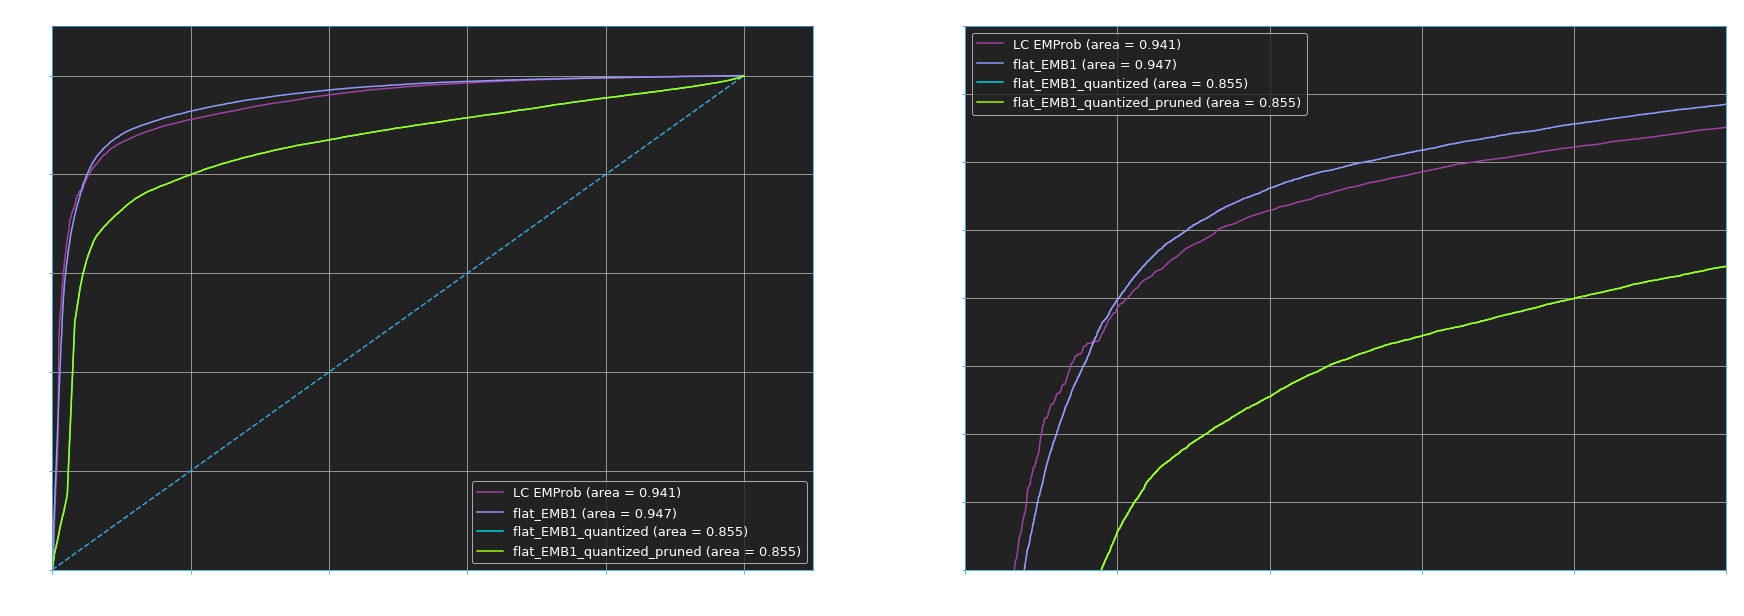

In [14]:
# Some hackery since model scores are now in 2 separate dictionaries.
scores_tmp = {}
for key,val in model_scores.items(): scores_tmp[key] = val
for key,val in qmodel_scores.items(): scores_tmp[key + '_quantized'] = val
for key,val in pmodel_scores.items(): scores_tmp[key + '_quantized_pruned'] = val

cpu.RocCurves(
    scores_tmp,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_flat',
    drawPlots=drawPlots,
    plotstyle=plotstyle,
    figsize=(30,10)
)

Let's also look at the cost reduction (here, energy consumption) to see how quantization has affected that.

In [ ]:
print('Cost reduction: {}'.format(GetCostReduction(qmodelfile)))